In [1]:
%matplotlib notebook
from matplotlib import rcParams
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as la

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.interpolate import interp2d

import scipy.fftpack as fft

import timeit

In [2]:
rcParams.update({'font.size': 12})

In [3]:
# To more easily compare with matlab outputs
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)

Here is the structure of the program:
* Setup grid and initialize variables
* $u^*$, $v^*$ = advectDiffuse
    * u_adv, v_adv are calculated from upwinding
    * update ghost nodes for implicit solve
    * calculate $u^*$ using sparse solver
    * calculate $v^*$ using sparse solver
    * update ghost nodes for explicit solve
* p, lgmult = pressure
    * calculate the divergence (ie right-hand side)
    * find pressure-correction using sparse solver and a Lagrange multiplier
    * update the ghost nodes
* $u^{n+1}$, $v^{n+1}$ = correct
    * compute the pressure gradient
    * calculate $u^{n+1}$ from $u^*$ and the pressure gradient
    * calculate $v^{n+1}$ from $v^*$ and the pressure gradient

# Parameters

# Functions

In [19]:
def setup_grid(m, h):
    grid = {}
    
    grid['mu'] = (m+2, m+1) # (muy, mux)
    grid['mv'] = (m+1, m+2) # (mvy, mvx)
    grid['mp'] = (m+2, m+2) # (mpy, mpx)
    
    # Laplacian for pressure
    
    D2x = 1/h**2 * sp.diags([ [-2]*m, [1]*(m-1), [1]*(m-1) ], offsets=[0,1,-1], format='lil')
    # modify for Neumann BCs
    D2x[ 0, 0] = -D2x[0,1]
    D2x[-1,-1] = -D2x[-1,-2]
    
    Lp = sp.lil_matrix((m**2+1, m**2+1))
    Lp[:-1,:-1] = sp.kron(D2x,sp.eye(m)) + sp.kron(sp.eye(m), D2x)
    # lagrange multiplier
    Lp[-1, :-1] = np.ones(m**2)
    Lp[:-1, -1] = np.ones(m**2).reshape((m**2,1))
    grid['Lp'] = Lp.tocsr()
    
    # Laplacian for diffusion of u
    mx, my = m-1, m
    D2x = 1/h**2 * sp.diags([ [-2]*mx, [1]*(mx-1), [1]*(mx-1) ], offsets=[0,1,-1], format='lil')
    D2y = 1/h**2 * sp.diags([ [-2]*my, [1]*(my-1), [1]*(my-1) ], offsets=[0,1,-1], format='lil')
    # Account for implicit boundary conditions
    D2y[ 0, 0] = -3*D2y[0,1]
    D2y[-1,-1] = -3*D2y[-1,-2]
    
    grid['Lu'] = sp.kron(D2x,sp.eye(my)) + sp.kron(sp.eye(mx), D2y)
    
    # Laplacian for diffusion of u
    mx, my = my, mx
    D2x = 1/h**2 * sp.diags([ [-2]*mx, [1]*(mx-1), [1]*(mx-1) ], offsets=[0,1,-1], format='lil')
    D2y = 1/h**2 * sp.diags([ [-2]*my, [1]*(my-1), [1]*(my-1) ], offsets=[0,1,-1], format='lil')
    # Account for implicit boundary conditions
    D2x[ 0, 0] = -3*D2x[0,1]
    D2x[-1,-1] = -3*D2x[-1,-2]
    
    grid['Lv'] = sp.kron(D2x,sp.eye(my)) + sp.kron(sp.eye(mx), D2y)
    
    return grid

def update_ghost_diffusion(u, v, ps, h, k, explicit=True):
    us = u.copy()
    vs = v.copy()
    
    # update u
    #   vertical
    us[:, 0] = np.zeros(len(us[:, 0]))
    us[:,-1] = np.zeros(len(us[:,-1]))
    #   horizontal
    us[0]  = 2*     k*np.diff(ps[ 1])/h  - explicit*us[ 1]
    us[-1] = 2*(1 + k*np.diff(ps[-2])/h) - explicit*us[-2]
    #   average corners
    us[ 0, 0] /= 2
    us[ 0,-1] /= 2
    us[-1, 0] /= 2
    us[-1,-1] /= 2
    
    # update v
    #   horizontal
    vs[ 0] = np.zeros(len(vs[ 0,:]))
    vs[-1] = np.zeros(len(vs[-1,:]))
    #   vertical
    vs[:, 0] = 2*k*np.diff(ps[:, 1])/h - explicit*vs[:, 1]
    vs[:,-1] = 2*k*np.diff(ps[:,-2])/h - explicit*vs[:,-2]
    #   average corners
    vs[ 0, 0] /= 2
    vs[ 0,-1] /= 2
    vs[-1, 0] /= 2
    vs[-1,-1] /= 2
    
    return us, vs
    
def ave_x(edge):
    return (edge[:,:-1] + edge[:,1:])/2
    
def ave_y(edge):
    return (edge[:-1,:] + edge[1:,:])/2

def ave_c(edge):
    ave = edge[:,:-1] + edge[:,1:]
    return (ave[:-1,:] + ave[1:,:])/4

def up_wind(us, vs, h, k):
    # compute (u,v).grad(u)
    U, V = ave_x(us[1:-1,:]), ave_x(vs[:,1:-1])
    
    pos_id = np.greater(U, 0)
    F = pos_id*us[1:-1,:-1] + np.logical_not(pos_id)*us[1:-1,1:]
    pos_id = np.greater(V, 0)
    G = pos_id*us[:-1,1:-1] + np.logical_not(pos_id)*us[1:,1:-1]
    # get v on vertical edges
    V = ave_c(vs[:,1:-1])
    u_adv = 1/h * (us[1:-1, 1:-1] * np.diff(F,1,1) + V*np.diff(G,1,0))
    
    # compute (u,v).grad(v)
    U, V = ave_y(us[1:-1,:]), ave_y(vs[:,1:-1])
    pos_id = np.greater(U, 0)
    F = pos_id*vs[1:-1,:-1] + np.logical_not(pos_id)*vs[1:-1,1:]
    pos_id = np.greater(V, 0)
    G = pos_id*vs[:-1,1:-1] + np.logical_not(pos_id)*vs[1:,1:-1]
    # get u on horizontal edges
    U = ave_c(us[1:-1,:])
    v_adv = 1/h * (vs[1:-1, 1:-1] * np.diff(G,1,0) + U*np.diff(F,1,1))
    
    return u_adv, v_adv

def laplacian(us, h):
    ret  = -4*us[1:-1, 1:-1]
    ret +=    us[ :-2, 1:-1]
    ret +=    us[1:-1,  :-2]
    ret +=    us[2:  , 1:-1]
    ret +=    us[1:-1, 2:  ]
    return ret/h**2

def advec_diffuse(us, vs, ps, h, k, Re, grid):
    u_adv, v_adv = up_wind(us, vs, h, k)
    u_star, v_star = update_ghost_diffusion(us, vs, ps, h, k, False)
    
    alpha = .5*k/Re
    
    # solve u first
    my, mx = [m-2 for m in us.shape]
    
    I = sp.eye(mx*my)
    # Compute right hand-side (I+L)*u on the grid.
    f = us[1:-1, 1:-1] + alpha*laplacian(us,h) - k*u_adv
    
    # incorporate boundary conditions
    f[0]   += alpha/h**2 * u_star[0   ,1:-1]
    f[-1]  += alpha/h**2 * u_star[-1  ,1:-1]
    f[:,0] += alpha/h**2 * u_star[1:-1, 0  ]
    f[:,-1]+= alpha/h**2 * u_star[1:-1, -1 ]
    f = f.T.flatten() # .flatten() stacks rows by default
    
    u_star[1:-1, 1:-1] = spla.spsolve(I - alpha*grid['Lu'], f).reshape(mx,my).T
    
    # solve v second
    my, mx = [m-2 for m in vs.shape]
    
    I = sp.eye(mx*my)
    # Compute right hand-side (I+L)*u on the grid.
    f = vs[1:-1, 1:-1] + alpha*laplacian(vs,h) - k*v_adv
    
    # incorporate boundary conditions
    f[0]   += alpha/h**2 * v_star[0   ,1:-1]
    f[-1]  += alpha/h**2 * v_star[-1  ,1:-1]
    f[:,0] += alpha/h**2 * v_star[1:-1, 0  ]
    f[:,-1]+= alpha/h**2 * v_star[1:-1, -1 ]
    
    f = f.T.flatten() # flatten stacks rows by default
    
    v_star[1:-1, 1:-1] = spla.spsolve(I - alpha*grid['Lv'], f).reshape(mx,my).T
    
    u_star, v_star = update_ghost_diffusion(u_star, v_star, ps, h, k, True)
    
    return u_star, v_star

def divergence(us, vs, h):
    return ( np.diff(us[1:-1],axis=1) + np.diff(vs[:,1:-1],axis=0) )/h

def pressure(u_star, v_star, h, k, grid):
    div = divergence(u_star, v_star, h)/k
    my, mx = div.shape
    
    rhs = np.zeros(mx*my+1)
    rhs[:-1] = div.T.flatten()
    
    pcr = spla.spsolve(grid['Lp'], rhs)
    
    lagrange_mult = pcr[-1]
    
    ps = np.zeros(grid['mp'])
    ps[1:-1, 1:-1] = pcr[:-1].reshape((my, mx)).T
    # ensure Neumann BCs
    ps[0] = ps[1]
    ps[-1] = ps[-2]
    ps[:,0] = ps[:,1]
    ps[:,-1] = ps[:,-2]
    
    return ps, lagrange_mult
    
def correct(us, vs, ps, h, k, grid):
    px = np.diff(ps[:,1:-1], axis=1)/h
    us[:,1:-1] -= k*px
    py = np.diff(ps[1:-1], axis=0)/h
    vs[1:-1,:] -= k*py
    return us, vs

def navier_stokes(m, L, CFL, Re, t0, t_final):
    h = L/m
    k = CFL*h
    t_steps = int((t_final-t0)/k)
    print('initializing...')
    grid = setup_grid(m, h)
    us = np.zeros(grid['mu'])
    vs = np.zeros(grid['mv'])
    ps = np.zeros(grid['mp'])
    
    print('solving')    
    for step in range(t_steps):
        if step % 100 == 0:
            print('step: %d/%d' % (step,t_steps), end='\r')
        u_star, v_star = advec_diffuse(us, vs, ps, h, k, Re, grid)
        ps, lagrange_mult = pressure(u_star, v_star, h, k, grid)
        us, vs = correct(u_star, v_star, ps, h, k, grid)
    print('complete                   ')
    return us, vs, ps, grid

# Timings

In [31]:
%%timeit -n1 -r1
m = 2**5 #2**5 #number of cell centers
L = 1    #length of side of square domain
CFL = .5 #max CFL number at which to run
Re = 100
t0, t_final = 0, 40

navier_stokes(m, L, CFL, Re, t0, t_final)

initializing...
solving
complete                   
36.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Solve

In [25]:
# parameters ************************************************************
m = 2**5 #number of cell centers
L = 1    #length of side of square domain
CFL = .5 #max CFL number at which to run

Re = 100

t0, t_final = 0, 40

In [26]:
us, vs, ps, grid = navier_stokes(m, L, CFL, Re, t0, t_final)

initializing...
solving
complete                   


# Compare to GGS82 and MSA09 data

In [27]:
muy, mux = grid['mu']
mvy, mvx = grid['mv']
mpy, mpx = grid['mp']
h = L/m
X_u, Y_u = np.meshgrid(np.linspace(0,L,mux), np.linspace(-h/2,L+h/2,muy))
X_v, Y_v = np.meshgrid(np.linspace(-h/2,L+h/2,mvx), np.linspace(0,L,mvy))
X_p, Y_p = np.meshgrid(np.linspace(-h/2,L+h/2,mpx), np.linspace(-h/2,L+h/2,mpy))

In [28]:
# plt.figure(figsize=(5,5))
# plt.plot([0,0], [0,h*8/2], 'k--')
# plt.plot([0, h*8/2], [0,0], 'k--')
# plt.plot(X_u[:5,:5].flatten(), Y_u[:5,:5].flatten(), 'b<', label='$u$')
# plt.plot(X_v[:5,:5].flatten(), Y_v[:5,:5].flatten(), 'gv', label='$v$')
# plt.plot(X_p[:5,:5].flatten(), Y_p[:5,:5].flatten(), 'ro', label='$p$')
# plt.legend()
# plt.show()

In [29]:
#data locations for u component of velocity from GGS82
idys = [128, 125, 124, 123, 122, 109, 94, 79, 64, 58, 36, 22, 13, 9, 8, 7, 0]
ys_uG = [i/128 for i in idys]
xs_uG = [.5]#*len(ys_uG)

#data locations for v component of velocity from GGS82
idx = [128, 124, 123, 122, 121, 116, 110, 103, 64, 30, 29, 20, 12, 10, 9, 8, 0]
xs_vG = [i/128 for i in idx]
ys_vG = [.5]#*len(xs_vM)

#data locations for u component of velocity from MSA09
ys_uM = np.linspace(0,1, 17)[1:-1]
xs_uM = [.5]#*len(ys_uM)

#data locations for v component of velocity from MSA09
xs_vM = np.linspace(0,1, 17)[1:-1]
ys_vM = [.5]#*len(xs_vM)



# Determine the values for comparison to GS82
if Re == 100:
    # Values of u at (xiu,yiu)
    uGGS82 = [1,0.84123,0.78871,0.73722,0.68717,0.23151,
              0.00332,-0.13641,-0.20581,-0.21090,-0.15662,
              -0.10150,-0.06434,-0.04775,-0.04192,-0.03717,0];
    uMSA09 = [-0.041974991, -0.077125399, -0.109816214, -0.141930064, 
              -0.172712391, -0.198470859, -0.212962392, -0.209149142, 
              -0.182080595, -0.131256301, -0.060245594, 0.027874448, 
              0.140425325, 0.310557090, 0.597466694]
    # Values of v at (xiv,yiv)
    vGGS82 = [0,-0.05906,-0.07391,-0.08864,-0.10313,-0.16914,
              -0.22445,-0.24533,0.05454,0.17527,0.17507,0.16077,
              0.12317,0.10890,0.10091,0.09233,0];
    vMSA09 = [0.094807616, 0.149243000, 0.174342933, 0.179243328, 
              0.169132064, 0.145730201, 0.108775865, 0.057536559, 
              -0.007748504, -0.084066715, -0.163010143, -0.227827313, 
              -0.253768577, -0.218690812, -0.123318170]
elif Re == 400:
    # Values of u at (xiu,yiu)
    uGGS82 = [1, 0.75837, 0.68439, 0.61756, 0.55892, 0.29093, 
              0.16256, 0.02135, -0.11477, -0.17119, -0.32726, 
              -0.24299, -0.14612, -0.10338, -0.09266, -0.08186, 0]
    uMSA09 = [-0.092599260, -0.178748051, -0.263917200, -0.321229080, 
              -0.320251090, -0.266306350, -0.190730560, -0.115053628, 
              -0.042568947, 0.030243020, 0.105456010, 0.181306850, 
              0.252203840, 0.316829690, 0.469580199]
    # Values of v at (xiv,yiv)
    vGGS82 = [0, -0.12146, -0.15663, -0.19254, -0.22847, -0.23827, 
              -0.44993, -0.38598, 0.05186, 0.30174, 0.30203, 0.28124, 
              0.22965, 0.20920, 0.19713, 0.18360, 0]
    vMSA09 = [0.185132290, 0.262251260, 0.297479230, 0.300960030, 
              0.268310960, 0.206571390, 0.130571694, 0.052058082, 
              -0.024714514, -0.100884164, -0.182109238, -0.280990219, 
              -0.400042350, -0.449011850, -0.270354943]
elif Re == 1000:
    # Values of u at (xiu,yiu)
    uGGS82 = [1,0.65928,0.57492,0.51117,0.46604,0.33304,0.18719,
              0.05702,-0.06080,-0.10648,-0.27805,-0.38289,-0.29370,
              -0.22220,-0.20196,-0.18109,0];
    uMSA09 = [-0.202330048, -0.347845100, -0.384409400, -0.318946100, 
              -0.245693700, -0.183732100, -0.123410460, -0.062056130, 
              0.000561800, 0.065248742, 0.133572570, 0.207914610, 
              0.288442400, 0.362545400, 0.422932100]
    # Values of v at (xiv,yiv)
    vGGS82 = [0,-0.21388,-0.27669,-0.33714,-0.39188,-0.51550,
              -0.42665,-0.31966,0.02526,0.32235,0.33075,0.37095,
              0.32627,0.30353,0.29012,0.27485,0]
    vMSA09 = [0.28070570, 0.36504180, 0.36785270, 0.30710428, 
              0.23126839, 0.16056422, 0.09296931, 0.02579946, 
              -0.04184068, -0.11079830, -0.18167970, -0.25338150, 
              -0.33156670, -0.46777560, -0.45615254]
    
# interpolate to values
us_interp_G = np.interp(ys_uG, Y_u[:,mux//2], us[:,mux//2])
us_interp_M = np.interp(ys_uM, Y_u[:,mux//2], us[:,mux//2])

vs_interp_G = np.interp(xs_vG, X_v[muy//2-1], vs[muy//2-1])
vs_interp_M = np.interp(xs_vM, X_v[muy//2-1], vs[muy//2-1])

<IPython.core.display.Javascript object>


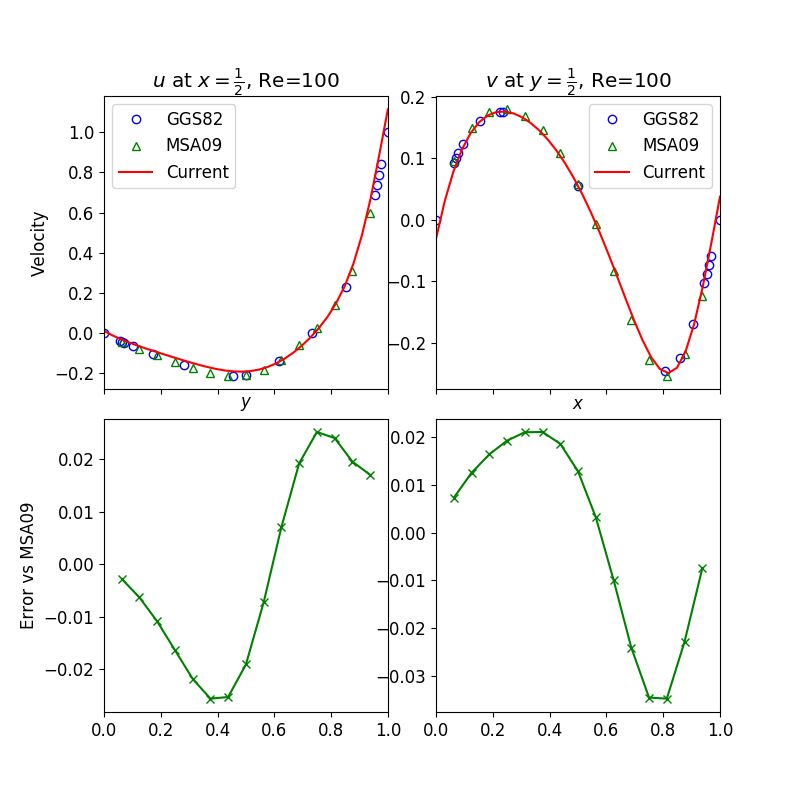

In [30]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(8,8))
plt.subplots_adjust(left=.13, wspace=.17, hspace=.1)

# plot u
axes[0,0].set_xlim((0,1))
axes[0,0].set_title('$u$ at $x=\\frac{1}{2}$, Re=%d' % Re)
axes[0,0].set_xlabel('$y$')
axes[0,0].set_ylabel('Velocity')
axes[0,0].plot(ys_uG, uGGS82, 'bo', fillstyle='none', label='GGS82')
axes[0,0].plot(ys_uM, uMSA09, 'g^', fillstyle='none', label='MSA09')
axes[0,0].plot(np.linspace(0,L,muy), us[:,mux//2], 'r-', label='Current')
axes[0,0].legend()

# plot u error vs MSA09
axes[1,0].set_ylabel('Error vs MSA09')
axes[1,0].plot(ys_uM, np.array(uMSA09)-us_interp_M.flatten(), 'gx-')

# plot v
axes[0,1].set_title('$v$ at $y=\\frac{1}{2}$, Re=%d' % Re)
axes[0,1].set_xlabel('$x$')
axes[0,1].plot(xs_vG, vGGS82, 'bo', fillstyle='none', label='GGS82')
axes[0,1].plot(xs_vM, vMSA09, 'g^', fillstyle='none', label='MSA09')
axes[0,1].plot(np.linspace(0,L,muy), vs[muy//2], 'r-', label='Current')
axes[0,1].legend()

#plot v error vs MSA09
axes[1,1].plot(xs_vM, np.array(vMSA09)-vs_interp_M.flatten(), 'gx-')

plt.show()